<a href="https://colab.research.google.com/github/VitaliiZaitsev/ApacheSpark/blob/main/Spark_Lesson_4_Vitaly_Zaitsev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Здравствуйте.

Spark умеет валидировать модели. Попробуем это сделать. Evaluation ипортируется следующим образом:


```
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
```

В частности [RegressionEvaluator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html#pyspark.ml.evaluation.RegressionEvaluator.metricName)

# Задание
Ниже обучается и оценивается модель. 

Нужно перевести этот в Pipeline (вам понадобится VectorAssembler), а затем рассчитать MAE (= Mean Absolute Error, Средний модуль отклонения) с помощью spark.

P.S.
В нотебуке скор считается через pandas и sklearn, сделайте это всё на spark + pipelines


## Подготовка датасета

Предлагается к использованию Boston House Prices, Regression predictive modeling machine learning problem from end-to-end Python

Описание: https://scikit-learn.org/stable/datasets/toy_dataset.html#boston-dataset

Ссылка на скачивание: https://www.kaggle.com/vikrishnan/boston-house-prices 

Оказалось, что явно скачивать датасет НЕ надо, пользуемся функцией sklearn.datasets.load_boston() В будущем функция будет выведена из использования, потребуется переделать работу с данными, см https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html


## Расчёт с помощью pandas и sklearn

### Установка пакетов

In [5]:
pip install pyspark

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 36.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=19cba7192d59fc81c418f6bc410f4cf9f9804a275fb917a6403692737a80572d
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


### Импорт модулей

In [6]:
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator

In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.regression import RandomForestRegressor

In [8]:
import pandas as pd
from sklearn.datasets import load_diabetes, load_iris, load_boston
from sklearn.metrics import mean_absolute_error

In [19]:
# Узнаем версию Pandas
print(pd.__version__)

1.1.5


### Spark context

In [9]:
spark = SparkSession.builder\
    .master("local[4]")\
    .appName("Lesson_4")\
    .config("spark.executor.instances",2)\
    .config("spark.executor.memory",'2g')\
    .config("spark.executor.cores",1)\
    .getOrCreate()
sc = spark.sparkContext

In [11]:
sc

<SparkContext master=local[4] appName=Lesson_4>

### Загрузка датасета

In [13]:
# Оказалось, что эта функция load_boston() выводится из обращения по этическим мотивам (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)
# Пока оставляем код as-is
data = load_boston()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [16]:
dataset = pd.DataFrame(data['data'], columns=data['feature_names'])
dataset['target'] = data['target']

In [23]:
# Посмотрим результат
dataset

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [27]:
cols_to_vector = F.udf(lambda l: Vectors.dense(l), VectorUDT())
spark_dataset = spark.createDataFrame(dataset).select(cols_to_vector(F.array(*data['feature_names'])).alias('features'), 'target').cache()

In [28]:
# Посмотрим что получилось
spark_dataset.show(3)

+--------------------+------+
|            features|target|
+--------------------+------+
|[0.00632,18.0,2.3...|  24.0|
|[0.02731,0.0,7.07...|  21.6|
|[0.02729,0.0,7.07...|  34.7|
+--------------------+------+
only showing top 3 rows



### Расщепление-тренировка

In [39]:
# Расщепляем датасет на два
train, test = spark_dataset.randomSplit([0.7, 0.3])

lr = RandomForestRegressor(labelCol='target')
lr = lr.fit(train)
train_predictions = lr.transform(train)
test_predictions = lr.transform(test)

### Расчёт Mean Absolute Error (средний модуль отклонения)

In [40]:
pandas_train_predictions = train_predictions.toPandas()
pandas_test_predictions = test_predictions.toPandas()

# Сам расчёт MAE (= Mean Absolute Error, Средний модуль отклонения)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
# from sklearn.metrics import mean_absolute_error
# y_true = [3, -0.5, 2, 7]
# y_pred = [2.5, 0.0, 2, 8]
# mean_absolute_error(y_true, y_pred)
# 0.5

print(f'''
    Scores:: 
        train: {mean_absolute_error(
            pandas_train_predictions.target, 
            pandas_train_predictions.prediction)}, 
        test: {mean_absolute_error(
            pandas_test_predictions.target, 
            pandas_test_predictions.prediction)}
    ''')


    Scores:: 
        train: 1.919364971777765, 
        test: 2.451392179008486
    


Получилось, что для train выборки средний модуль отклонения = 1.91, а для test выборки он больше и = 2.45, при этом размеры выборок были заданы вот так 
train, test = spark_dataset.randomSplit([0.7, 0.3])

В общем результаты сравнимы и понятны


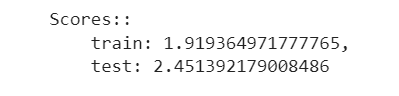

## Расчёт с помощью spark + pipelines

### Импорт модулей

In [41]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

### Загрузка датасета

In [42]:
# Всё тот же Бостон набор данных
data = load_boston()
dataset = pd.DataFrame(data['data'], columns=data['feature_names'])
dataset['target'] = data['target']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [44]:
# Формируем spark датасет
spark_dataset_for_linear_regression = spark.createDataFrame(dataset)

In [47]:
# Посмотрим схему
spark_dataset_for_linear_regression.printSchema()

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: double (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: double (nullable = true)
 |-- TAX: double (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- target: double (nullable = true)



In [48]:
# И данные
spark_dataset_for_linear_regression.show(3)

+-------+----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+------+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM| AGE|   DIS|RAD|  TAX|PTRATIO|     B|LSTAT|target|
+-------+----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+------+
|0.00632|18.0| 2.31| 0.0|0.538|6.575|65.2|  4.09|1.0|296.0|   15.3| 396.9| 4.98|  24.0|
|0.02731| 0.0| 7.07| 0.0|0.469|6.421|78.9|4.9671|2.0|242.0|   17.8| 396.9| 9.14|  21.6|
|0.02729| 0.0| 7.07| 0.0|0.469|7.185|61.1|4.9671|2.0|242.0|   17.8|392.83| 4.03|  34.7|
+-------+----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+------+
only showing top 3 rows



In [50]:
# Магия векторизации
data_v = VectorAssembler(
    inputCols=["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"],
    outputCol="features")
out_data = data_v.transform(spark_dataset_for_linear_regression).select('features', 'target')

### Расщепление-тренировка

In [59]:
# Снова расщепляем датасет на два, коэффициенты те же: 0,7 и 0,3
(train, test) = spark_dataset_for_linear_regression.randomSplit([0.7, 0.3])

lr = RandomForestRegressor(featuresCol='features',labelCol='target')

In [60]:
train.count()

339

In [61]:
train.show(3)

+-------+-----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+------+
|   CRIM|   ZN|INDUS|CHAS|  NOX|   RM| AGE|   DIS|RAD|  TAX|PTRATIO|     B|LSTAT|target|
+-------+-----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+------+
|0.01311| 90.0| 1.22| 0.0|0.403|7.249|21.9|8.6966|5.0|226.0|   17.9|395.93| 4.81|  35.4|
| 0.0136| 75.0|  4.0| 0.0| 0.41|5.888|47.6|7.3197|3.0|469.0|   21.1| 396.9| 14.8|  18.9|
|0.01432|100.0| 1.32| 0.0|0.411|6.816|40.5|8.3248|5.0|256.0|   15.1| 392.9| 3.95|  31.6|
+-------+-----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+------+
only showing top 3 rows



In [62]:
test.count()

167

In [63]:
test.show(3)

+-------+----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+------+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM| AGE|   DIS|RAD|  TAX|PTRATIO|     B|LSTAT|target|
+-------+----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+------+
|0.00632|18.0| 2.31| 0.0|0.538|6.575|65.2|  4.09|1.0|296.0|   15.3| 396.9| 4.98|  24.0|
|0.02055|85.0| 0.74| 0.0| 0.41|6.383|35.7|9.1876|2.0|313.0|   17.3| 396.9| 5.77|  24.7|
|0.02729| 0.0| 7.07| 0.0|0.469|7.185|61.1|4.9671|2.0|242.0|   17.8|392.83| 4.03|  34.7|
+-------+----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+------+
only showing top 3 rows



### Расчёт Mean Absolute Error (средний модуль отклонения)

In [66]:
pipeline = Pipeline(stages=[data_v, lr])
model = pipeline.fit(train)

In [67]:
prediction_train = model.transform(train)
prediction_test = model.transform(test)

In [68]:
pr_train = prediction_train.toPandas()
pr_test = prediction_test.toPandas()
print(f'''
    Scores:: 
        train: {mean_absolute_error(
            pr_train['target'], 
            pr_train['prediction'])},
        test: {mean_absolute_error(
            pr_test['target'], 
            pr_test['prediction'])}
    ''')


    Scores:: 
        train: 1.8564304322482708,
        test: 2.3487799524348976
    


Итоги:
1. Для pandas и sklearn MEA равно:
train выборка = 1.91
test выборка = 2.45

2. Для spark + pipelnies MAE равно
train выборка = 1.86
test выборка = 2.35

Результаты сравнимы

# END